In [37]:
from surprise import evaluate, Reader, Dataset, SVD, NMF, GridSearch, KNNWithMeans
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
%matplotlib inline

In [15]:
ratings = pd.read_csv('../raw-data/BX-Book-Ratings.csv', encoding='iso-8859-1', sep = ';')
ratings.columns = ['user_id', 'isbn', 'book_rating']

In [16]:
books = pd.read_csv('../raw-data/BX-Books.csv', sep=';', encoding = 'iso-8859-1', dtype =str)
del books['Image-URL-L']
del books['Image-URL-M']
del books['Image-URL-S']
del books['Book-Author']
del books['Publisher']

In [17]:
print('Number of Books == Number of ISBN ? ', books["Book-Title"].nunique() == books["ISBN"].nunique())
book_dict = books[["Book-Title","ISBN"]].set_index("Book-Title").to_dict()["ISBN"]
books['new_isbn'] = books["Book-Title"].apply(lambda x: book_dict[x])
print('Number of Books == Number of ISBN ? ', books["Book-Title"].nunique() == books["new_isbn"].nunique())

('Number of Books == Number of ISBN ? ', False)
('Number of Books == Number of ISBN ? ', True)


In [18]:
books['isbn'] = books['new_isbn']

del books['ISBN']
del books['new_isbn']

In [19]:
newdf = ratings[ratings.book_rating>0]
joined = books.merge(newdf, on ='isbn')
print(newdf.shape)

(433671, 3)


In [20]:
datasets = []
for j in [100, 150, 200, 300, 500]:
    df = joined.groupby('isbn').count().sort_values('user_id', ascending =False)[0:j].index.values
    test = joined.groupby('user_id').count().sort_values('isbn', ascending = False)[:20000].index.values
    newdf = joined[joined.user_id.isin(test) & joined.isbn.isin(df)]
    data  = newdf[newdf['user_id'].isin(newdf['user_id'].value_counts()[newdf['user_id'].value_counts()>1].index)]
    print("users books")
    print(data.user_id.nunique(), data.isbn.nunique())
    print()
    print(data.shape)
    print()
    print(data.groupby('user_id').count().sort_values('isbn', ascending = False).mean())
    print()
    datasets.append(data)

users books
(2517, 100)
()
(8242, 5)
()
Book-Title             3.274533
Year-Of-Publication    3.274533
isbn                   3.274533
book_rating            3.274533
dtype: float64
()
users books
(3086, 150)
()
(10829, 5)
()
Book-Title             3.509073
Year-Of-Publication    3.509073
isbn                   3.509073
book_rating            3.509073
dtype: float64
()
users books
(3543, 200)
()
(13271, 5)
()
Book-Title             3.745696
Year-Of-Publication    3.745696
isbn                   3.745696
book_rating            3.745696
dtype: float64
()
users books
(4280, 300)
()
(17160, 5)
()
Book-Title             4.009346
Year-Of-Publication    4.009346
isbn                   4.009346
book_rating            4.009346
dtype: float64
()
users books
(5282, 500)
()
(23181, 5)
()
Book-Title             4.388679
Year-Of-Publication    4.388679
isbn                   4.388679
book_rating            4.388679
dtype: float64
()


In [21]:
data = datasets[0]
rows = data.user_id.unique()
cols = data['Book-Title'].unique()
print(data.user_id.nunique(), data.isbn.nunique())
data = data[['user_id', 'Book-Title', 'book_rating']]

(2517, 100)


In [22]:
idict  = dict(zip(cols, range(len(cols))))
udict = dict(zip(rows, range(len(rows))))

data.user_id = [
    udict[i] for i in data.user_id
]
data['Book-Title'] = [
    idict[i] for i in data['Book-Title']
]

nmat = data.as_matrix()


C:\Users\vijay\Anaconda2\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\vijay\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
reader = Reader(rating_scale=(1, 10))
data2 = Dataset.load_from_df(data[['user_id', 'Book-Title', 'book_rating']], reader)
data2.split(5)


In [26]:
param_grid = {'n_factors': [30, 40, 50, 60, 70], 'n_epochs': [40, 50, 60], 'reg_pu': [0.001, 0.1, 1],
              'reg_qi': [ 0.1, 1, 3, 5]}
grid_search = GridSearch(NMF, param_grid, measures=['RMSE', 'MAE'])
grid_search.evaluate(data2)
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
print(results_df)

[{'n_factors': 30, 'reg_qi': 0.1, 'reg_pu': 0.001, 'n_epochs': 40}, {'n_factors': 30, 'reg_qi': 0.1, 'reg_pu': 0.001, 'n_epochs': 50}, {'n_factors': 30, 'reg_qi': 0.1, 'reg_pu': 0.001, 'n_epochs': 60}, {'n_factors': 30, 'reg_qi': 0.1, 'reg_pu': 0.1, 'n_epochs': 40}, {'n_factors': 30, 'reg_qi': 0.1, 'reg_pu': 0.1, 'n_epochs': 50}, {'n_factors': 30, 'reg_qi': 0.1, 'reg_pu': 0.1, 'n_epochs': 60}, {'n_factors': 30, 'reg_qi': 0.1, 'reg_pu': 1, 'n_epochs': 40}, {'n_factors': 30, 'reg_qi': 0.1, 'reg_pu': 1, 'n_epochs': 50}, {'n_factors': 30, 'reg_qi': 0.1, 'reg_pu': 1, 'n_epochs': 60}, {'n_factors': 30, 'reg_qi': 1, 'reg_pu': 0.001, 'n_epochs': 40}, {'n_factors': 30, 'reg_qi': 1, 'reg_pu': 0.001, 'n_epochs': 50}, {'n_factors': 30, 'reg_qi': 1, 'reg_pu': 0.001, 'n_epochs': 60}, {'n_factors': 30, 'reg_qi': 1, 'reg_pu': 0.1, 'n_epochs': 40}, {'n_factors': 30, 'reg_qi': 1, 'reg_pu': 0.1, 'n_epochs': 50}, {'n_factors': 30, 'reg_qi': 1, 'reg_pu': 0.1, 'n_epochs': 60}, {'n_factors': 30, 'reg_qi': 1,

In [27]:
print(grid_search.best_score['RMSE'])
print(grid_search.best_params['RMSE'])
print(grid_search.best_score['MAE'])
print(grid_search.best_params['MAE'])


1.53803399255
{'n_factors': 70, 'reg_qi': 5, 'reg_pu': 0.001, 'n_epochs': 40}
0.976375653981
{'n_factors': 60, 'reg_qi': 5, 'reg_pu': 0.001, 'n_epochs': 60}


In [28]:
maelist = []
rmselist = []
factors = [20, 30, 40 ,50 ,60, 70, 80]
for i in factors:
    algo = NMF(n_factors = i, reg_pu = 0.001, reg_qi = 5)
    perf = evaluate(algo, data2)
    maelist.append(np.mean(perf['mae']))
    rmselist.append(np.mean(perf['rmse']))
    

Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 1.5526
MAE:  1.0025
------------
Fold 2
RMSE: 1.5467
MAE:  1.0025
------------
Fold 3
RMSE: 1.5911
MAE:  1.0222
------------
Fold 4
RMSE: 1.5835
MAE:  1.0308
------------
Fold 5
RMSE: 1.5681
MAE:  1.0278
------------
------------
Mean RMSE: 1.5684
Mean MAE : 1.0172
------------
------------
Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 1.5383
MAE:  0.9773
------------
Fold 2
RMSE: 1.5421
MAE:  0.9971
------------
Fold 3
RMSE: 1.5806
MAE:  1.0007
------------
Fold 4
RMSE: 1.5955
MAE:  1.0291
------------
Fold 5
RMSE: 1.5596
MAE:  0.9876
------------
------------
Mean RMSE: 1.5632
Mean MAE : 0.9984
------------
------------
Evaluating RMSE, MAE of algorithm NMF.

------------
Fold 1
RMSE: 1.5224
MAE:  0.9622
------------
Fold 2
RMSE: 1.5365
MAE:  0.9884
------------
Fold 3
RMSE: 1.5746
MAE:  0.9964
------------
Fold 4
RMSE: 1.5824
MAE:  1.0132
------------
Fold 5
RMSE: 1.5329
MAE:  0.9857
------------
-

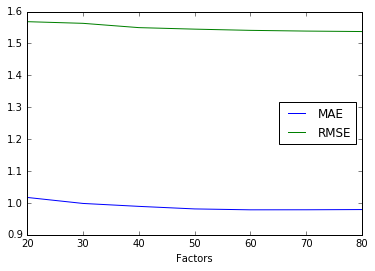

In [29]:
results_df = pd.DataFrame({'Factors': factors, 'MAE': maelist, 'RMSE': rmselist})
results_df.plot(x='Factors', y=['MAE', 'RMSE'], ylim=(0.9, 1.6))

In [30]:
maelist

[1.0171529852834555,
 0.99835416812690014,
 0.98918001500927166,
 0.98116939471531306,
 0.97834896110970604,
 0.97850322755757535,
 0.97917182995315921]

In [31]:
from collections import defaultdict
def get_top_n(predictions, n=10):

    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


trainset = data2.build_full_trainset()
algo = NMF(n_epochs = 60, n_factors = 70, reg_pu = 0.001, reg_qi = 5)
algo.train(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user


In [32]:
def recbooks(mat, user_id, idict, cov = False):
    full_mat = np.zeros((len(rows),len(cols)))
    for row in mat:
        full_mat[row[0], row[1]] = row[2]
    
    nzero = full_mat[user_id].nonzero()[0]
    
    flipped_dict = dict(zip(idict.values(), idict.keys()))
    ans = [flipped_dict[i[0]] for i in top_n[user_id]]
    if not cov:
        print("Books Read -----")
        for i in nzero:
            print(flipped_dict[i])
        print()
        print("Recs -----")
        for i in ans:
            print(i)
    return ans

recbooks(nmat, 1,idict)

Books Read -----
Beloved (Plume Contemporary Fiction)
Wicked: The Life and Times of the Wicked Witch of the West
The Red Tent (Bestselling Backlist)
The Nanny Diaries: A Novel
The Amazing Adventures of Kavalier &amp; Clay
Bel Canto: A Novel
Year of Wonders
()
Recs -----
Harry Potter and the Goblet of Fire (Book 4)
Middlesex: A Novel
A Wrinkle In Time
Cat &amp; Mouse (Alex Cross Novels)
The Lovely Bones: A Novel
Into Thin Air : A Personal Account of the Mt. Everest Disaster
Good Omens
Tears of the Giraffe (No.1 Ladies Detective Agency)
It Was on Fire When I Lay Down on It
The Alchemist: A Fable About Following Your Dream


[u'Harry Potter and the Goblet of Fire (Book 4)',
 u'Middlesex: A Novel',
 u'A Wrinkle In Time',
 u'Cat &amp; Mouse (Alex Cross Novels)',
 u'The Lovely Bones: A Novel',
 u'Into Thin Air : A Personal Account of the Mt. Everest Disaster',
 u'Good Omens',
 u'Tears of the Giraffe (No.1 Ladies Detective Agency)',
 u'It Was on Fire When I Lay Down on It',
 u'The Alchemist: A Fable About Following Your Dream']

In [33]:
for m in [5, 8, 10, 15]:   
    cov = []
    top_n = get_top_n(predictions, m)
    for i in range(len(rows)):
        cov.extend(recbooks(nmat, i,idict, True))
    print("Coverage with", m, "recs:", len(set(cov)), "%")

('Coverage with', 5, 'recs:', 85, '%')
('Coverage with', 8, 'recs:', 90, '%')
('Coverage with', 10, 'recs:', 93, '%')
('Coverage with', 15, 'recs:', 94, '%')


In [38]:
trtimer = []
tetimer = []
for data4 in datasets:
    rows4 = data4.user_id.unique()
    cols4 = data4['Book-Title'].unique()
    print(data4.user_id.nunique(), data4.isbn.nunique())
    data4 = data4[['user_id', 'Book-Title', 'book_rating']]
    
    idict  = dict(zip(cols4, range(len(cols4))))
    udict = dict(zip(rows4, range(len(rows4))))
    
    data4.user_id = [
    udict[i] for i in data4.user_id
    ]
    data4['Book-Title'] = [
    idict[i] for i in data4['Book-Title']
    ]
    
    trainset = data2.build_full_trainset()
    algo = NMF(n_epochs = 60, n_factors = 70, reg_pu = 0.001, reg_qi = 5)
    
    start = time.time()
    algo.train(trainset)
    end = time.time()
    
    trt = end - start
    print(trt)
    
    testset = trainset.build_anti_testset()
    
    start = time.time()
    predictions = algo.test(testset)
    end = time.time()
    
    tet = end - start
    print(tet)
    
    trtimer.append(trt)
    tetimer.append(tet)

    print()


(2517, 100)


C:\Users\vijay\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.44000005722
2.02200007439
()
(3086, 150)
1.85399985313
1.70200014114
()
(3543, 200)
1.32799983025
1.45000004768
()
(4280, 300)
1.36599993706
1.53200006485
()
(5282, 500)
1.28799986839
1.60700011253
()


In [ ]:
sim_options = {
    'name': 'cosine',
    'user_based' : False
}
algo = KNNWithMeans(sim_options = sim_options, k = 10, min_k =2)

In [ ]:
perf = evaluate(algo, data1)